In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from tomopt.muon import *
from tomopt.inference import *
from tomopt.volume import *
from tomopt.core import *
from tomopt.optimisation import *

import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np

import torch
from torch import Tensor, nn
import torch.nn.functional as F

# Basics

In [3]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

In [4]:
def eff_cost(x:Tensor) -> Tensor:
    return torch.expm1(3*F.relu(x))

In [5]:
def res_cost(x:Tensor) -> Tensor:
    return F.relu(x/100)**2

In [6]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    pos = 'above'
    for z,d in zip(np.arange(lwh[2],0,-size), [1,1,0,0,0,0,0,0,1,1]):
        if d:
            layers.append(DetectorLayer(pos=pos, init_eff=init_eff, init_res=init_res,
                                        lw=lwh[:2], z=z, size=size, eff_cost_func=eff_cost, res_cost_func=res_cost))
        else:
            pos = 'below'
            layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))

    return nn.ModuleList(layers) 

In [7]:
volume = Volume(get_layers())

# VolumeWrapper

In [8]:
from functools import partial

In [9]:
volume = Volume(get_layers())

In [11]:
class VarianceDetectorLoss(DetectorLoss):
    def forward(self, pred_x0: Tensor, pred_weight: Tensor, volume: Volume) -> Tensor:
        self.sub_losses["variance"] = torch.mean(1/pred_weight)  # SE/variance
        cost = volume.get_cost()
        if self.cost_coef is None:
            self._compute_cost_coef(cost, self.sub_losses["variance"])
        self.sub_losses["cost"] = self.cost_coef * cost
        return self.sub_losses["variance"] + self.sub_losses["cost"]

In [12]:
wrapper = VolumeWrapper(volume=volume, res_opt=partial(torch.optim.SGD, lr=2e9), eff_opt=partial(torch.optim.SGD, lr=2e2),
                        loss_func=VarianceDetectorLoss())

In [13]:
from tomopt.optimisation import MetricLogger

In [19]:
ml = MetricLogger(show_plots=True)

In [20]:
trn_passives = PassiveYielder([arb_rad_length])

In [21]:
from tomopt.optimisation.callbacks.callback import Callback

In [22]:
class ParamCap(Callback):
    def on_volume_batch_begin(self) -> None:
        with torch.no_grad():
            for d in self.wrapper.volume.get_detectors():
                torch.clamp_(d.resolution, min=1, max=1e7)
                torch.clamp_(d.efficiency, min=1e-7, max=1)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



Traceback (most recent call last):
  File "/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 1, in <module>
  File "/Users/giles/cernbox/mode_muon_tomography/tomopt/optimisation/wrapper/volume_wrapper.py", line 289, in fit
    c.on_train_begin()
  File "/Users/giles/cernbox/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py", line 115, in on_train_begin
    self._reset()
  File "/Users/giles/cernbox/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py", line 76, in _reset
    self._prep_plots()
  File "/Users/giles/cernbox/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py", line 107, in _prep_plots
    self.display = display(self.fig, display_id=True)
  File "/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/IPython/core/display.py", line 313, in display
    format_dict, md_dict = format(obj, include=include, exclu

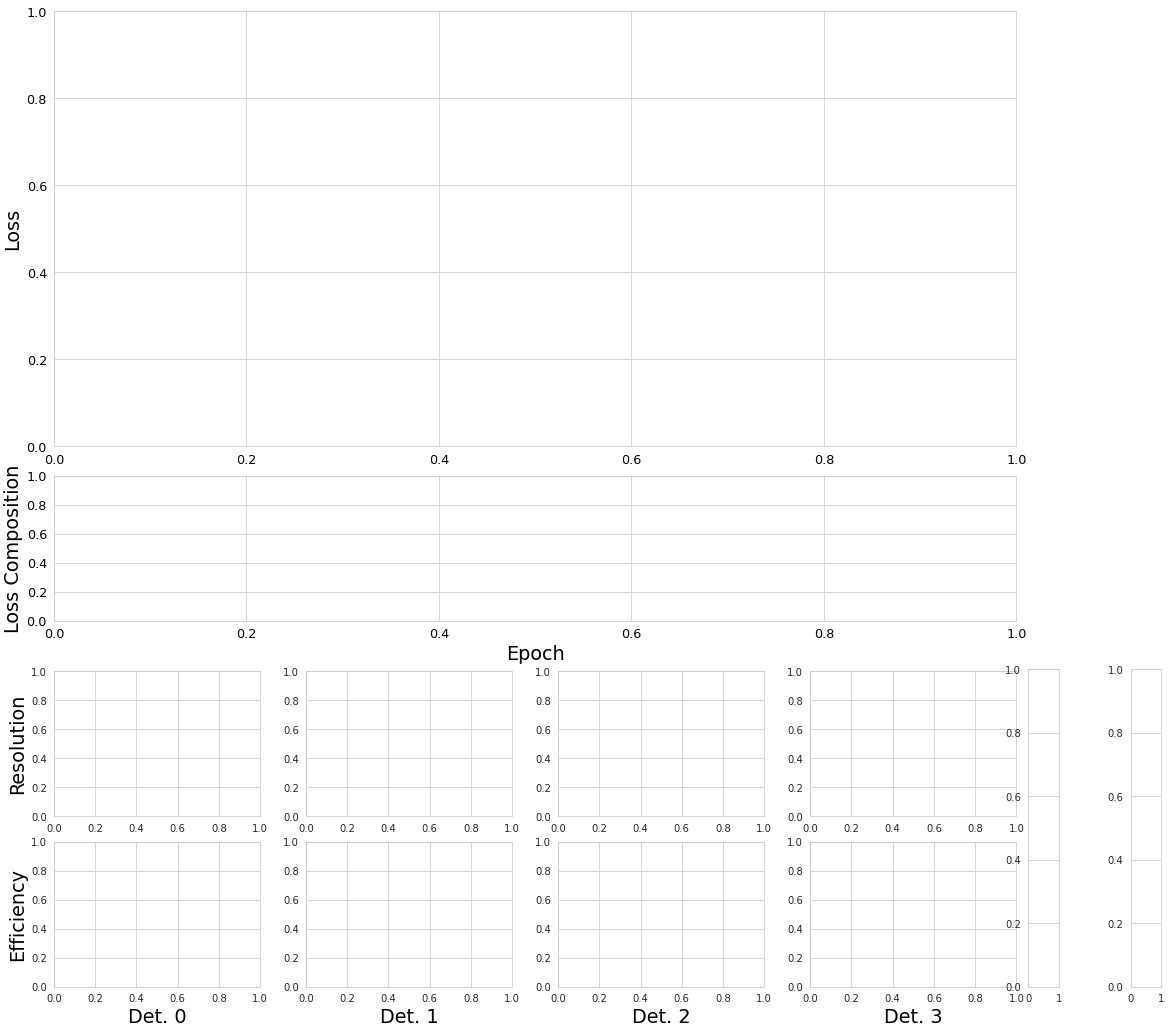

In [23]:
%%time
_ = wrapper.fit(25, n_mu_per_volume=1000, mu_bs=100, passive_bs=1, trn_passives=trn_passives, val_passives=trn_passives, cbs=[NoMoreNaNs(),ParamCap(),ml])

In [18]:
for d in volume.get_detectors():
    print(1, d.resolution, d.efficiency)

1 Parameter containing:
tensor([[ 944.7238,  879.3392,  942.0074,  839.4045,  926.0201,  770.4169,
          876.3475,  887.1107,  940.6292,  900.8568],
        [ 824.4638,  869.1426,  884.6584,  783.0872,  903.0166,  922.0774,
          911.3770,  894.8262,  924.1179, 1971.4182],
        [ 914.6912,  885.4609,  922.8918,  940.1758,  885.3452,  911.1371,
          935.6091,  874.1616,  874.5265, 1061.8381],
        [ 893.5571,  913.2275,  951.3462,  942.1079,  944.5255,  933.7513,
          925.4319,  935.7755,  891.9627,  872.7415],
        [ 872.5511,  914.8224,  937.0390,  926.0547,  937.7984,  927.1053,
          919.9775,  953.5624,  930.6780,  886.4045],
        [ 894.3889,  940.6751,  950.0142,  932.5651,  916.1715,  953.6664,
          960.7090,  958.1313,  924.0609,  906.8161],
        [ 910.0916,  918.1438,  930.4972,  934.1456,  944.2277,  966.1574,
          959.1130,  961.3692,  907.6937,  921.1329],
        [ 882.7684,  926.7073,  928.1646,  935.5862,  941.2750,  957.0908